In [21]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
#load data
dt = pd.read_csv('Reviews.csv')
dt.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [23]:
#trim data into 3000 rows with random state 42
dt = dt.sample(n=3000, random_state=42)

In [24]:
#drop id, profile name, and time
dt = dt.drop(['Id', 'ProfileName', 'Time'], axis=1)

In [25]:
dt.isnull().sum()


ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Summary                   0
Text                      0
dtype: int64

In [26]:
dt = dt.dropna()

In [27]:
def preprocess (text):
    #lower case
    text = text.lower()
    #tokenization
    tokens = word_tokenize(text)
    #stopwords removal
    stopwords_ = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stopwords_]
    #stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    #join back into string
    return ' '.join(stemmed_tokens)

#applu preprocess to review text
dt['CleanedText'] = dt['Text'].apply(preprocess)

In [28]:
#aspect identification
nlp = spacy.load('en_core_web_sm')
def extract_aspect(text):
    doc = nlp(text)
    aspects = []
    for token in doc:
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            aspects.append(token.text)
    return aspects
#apply extract_aspect to cleaned text
dt['Aspects'] = dt['CleanedText'].apply(extract_aspect)

In [29]:
dt['Aspects']

165256    [best, true, satisfi, sweet, good, someth, glu...
231465                                     [top, flip, top]
427827                                                   []
433954    [first, -, wheat, mini, -, wheat, much, frost,...
70260          [graphic, entir, small, serious, good, free]
                                ...                        
76617                     [bitter, strong, enough, smaller]
154233    [amish, countri, red, amish, countri, red, inc...
255097     [tri, nice, nice, hot, great, wild, sauc, great]
396416                                [red, open, red, new]
418835                         [coffe, good, strong, sweet]
Name: Aspects, Length: 3000, dtype: object

In [30]:
#sentiment labeling
def sentiment_label(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    elif score > 3:
        return 'positive'
#apply sentiment_label to score
dt['Sentiment'] = dt['Score'].apply(sentiment_label)

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return vader.polarity_scores(text)['compound']
dt['Vader'] = dt['CleanedText'].apply(vader_sentiment)

In [32]:
dt['Vader']

165256    0.9583
231465    0.9715
427827    0.0000
433954    0.9893
70260     0.9287
           ...  
76617     0.8779
154233    0.9583
255097    0.9758
396416    0.7345
418835    0.8481
Name: Vader, Length: 3000, dtype: float64

In [33]:
#displaying some sample reviews
def display_sample_reviews(dt, n=10):
    for i, row in dt.sample(n).iterrows():
        print(row['Text'])
        print(f"Sentiment: {row['Sentiment']}")
        print(f"Vader: {row['Vader']}")
        print()
display_sample_reviews(dt, n=5)

My son was delighted to receive this as a gift for Christmas.  Awhile back we were given a gift pack of various salts and this flavor was his favorite.  It quickly was consumed and he commented about how much he missed this item.  Now he has a replenished supply.  We paired it with a bamboo salt box for a really unusual gift.
Sentiment: positive
Vader: 0.9001

These taste great, and they are so airy like cheetoes puffs but not all greasy.  Sodium is lower than most other salty snacks but still sates my craving.  Great product!!
Sentiment: positive
Vader: 0.8774

We purchase this tea primarily for keeping our fridge well stocked with iced tea year round, and for that it is really quite tasty.  This particular brand/blend really seems to emphasize the fruitiness of the bergamot -- it's oddly reminiscent of lychee, which we rather like.  The "black"ness, however, is quite mild, so if I'm drinking it hot I brew it a bit longer and it still comes out pretty well.
Sentiment: positive
Vader: 

This stuff sounded perfect...way too much red dye and no taste according to me and my 3 friends who tried it...kind of salty.  Basically, I would stay away from it.  I am tempted to toss it out, but paid too much to feel right about it...

Sentiment: negative

Vader: 0.8834

in one of the sample it's a clear mismatch, the sentiment is negative, but VADER find it as positive, this highlights the importance of text analysis. sarcasm, negation, etc are hard to deduce from te star rating alone.

In [34]:
dt.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText,Aspects,Sentiment,Vader
165256,B000EVG8J2,A1L01D2BD3RKVO,0,0,5,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,"tri coupl brand gluten-fre sandwich cooki , be...","[best, true, satisfi, sweet, good, someth, glu...",positive,0.9583
231465,B0000BXJIS,A3U62RE5XZDP0G,0,0,5,great kitty treats,My cat loves these treats. If ever I can't fin...,"cat love treat . ever ca n't find hous , pop t...","[top, flip, top]",positive,0.9715
427827,B008FHUFAU,AOXC0JQQZGGB6,0,2,3,COFFEE TASTE,A little less than I expected. It tends to ha...,littl less expect . tend muddi tast - expect s...,[],neutral,0.0000
433954,B006BXV14E,A3PWPNZVMNX3PA,0,1,2,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...","first frost mini-wheat , origin size , frost m...","[first, -, wheat, mini, -, wheat, much, frost,...",negative,0.9893
70260,B007I7Z3Z0,A1XNZ7PCE45KK7,0,2,5,Great Taste . . .,and I want to congratulate the graphic artist ...,want congratul graphic artist put entir produc...,"[graphic, entir, small, serious, good, free]",positive,0.9287


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dt['CleanedText'])

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, dt['Sentiment'], test_size=0.2, random_state=42)

# Training model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Testing model
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Predicting sentiment
def predict_sentiment(text):
    text = preprocess(text)
    X = vectorizer.transform([text])
    sentiment = model.predict(X)[0]
    return sentiment


Accuracy: 0.7983333333333333
Confusion Matrix:
[[ 10   0  76]
 [  0   0  44]
 [  1   0 469]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.12      0.21        86
     neutral       0.00      0.00      0.00        44
    positive       0.80      1.00      0.89       470

    accuracy                           0.80       600
   macro avg       0.57      0.37      0.36       600
weighted avg       0.75      0.80      0.72       600



c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


wtih overall accuracy of 80% i think it is solid enough considering complexities of sentiment analysis.

this model excels at identyfying positive reviews with recall of 0.1, it aligns well with the tendention of food reviews is positively skewed.

In [56]:
#extracting missclassified reviews
def display_misclassified_reviews(dt):
    dt['Predicted'] = dt['Text'].apply(predict_sentiment)
    misclassified = dt[dt['Sentiment'] != dt['Predicted']]
    for i, row in misclassified.iterrows():
        print(row['Text'])
        print(f"Actual: {row['Sentiment']}")
        print(f"Predicted: {row['Predicted']}")
        print()
display_misclassified_reviews(dt.sample(10))

Not caring for regular tea or the caffeine, I drink herbal tea exclusively and am always on the lookout for fun new flavors.  This Blackberry Vanilla sounded delicious,, not a flavor combination I had seen before.  I should also mention that my true test for how well I end up really liking a tea's flavor is whether or not I need sweetener.  If I need it then the flavor is most likely too bitter for me.<br /><br />Out of the box, the tea bags have a bit of a dried flowers smell, not very fruity.  However, when it is brewing the fragrance is delicious!  The berries wake up, and the vanilla too.<br /><br />I tried this tea both hot and iced.  As a hot tea, the flavor was alright, but it was like there were too many herbs and not enough berries.  I did end up needing a bit of sweetener, as I felt the flavor was too earthy.  The vanilla was too subtle to detect.<br /><br />It was when I tried this tea iced that I found I really enjoyed it.  The cold seems to suit the berry flavors nicely, I

these are some of the misclassified reviews. my hypotheses is, they are predicted as positive because the reviews it self contain some positive word in the review

my guess is it's due to usage of 
Bag-of-Words Representation and TF-IDF my models relied on

Bag-of-Words Representation: Treats the review as a collection of individual words, losing some of the order and context.

TF-IDF: Emphasizes words that distinguish between documents. This could overvalue occasional positive words in primarily negative reviews.

using neural network as model choise might be a strategic solutions since it can be trained to learn more complex patterns of how words in sequence convey sentiment.

In [37]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [38]:
# Convert Series to NumPy array
y_train = np.asarray(y_train)  
y_test =  np.asarray(y_test)

# One-hot encode labels in a way consistent with your data format
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
y_train_ohe = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_ohe  = encoder.transform(y_test.reshape(-1, 1)) 

# Define model with regularization
model = Sequential()
#dense layer with 128 neurons and relu activation function
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  
#output layer with 3 neurons and softmax activation function
#matching the number of sentiment classes
model.add(Dense(3, activation='softmax')) 

# Compilation (no changes needed)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training (using encoded labels)
model.fit(X_train, y_train_ohe, epochs=10, batch_size=42, validation_data=(X_test, y_test_ohe)) 

# Evaluation (using encoded labels)
loss, accuracy = model.evaluate(X_test, y_test_ohe)
print(f'Test Accuracy: {accuracy}') 

c:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7339 - loss: 0.9190 - val_accuracy: 0.7833 - val_loss: 0.6294
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7993 - loss: 0.5369 - val_accuracy: 0.7833 - val_loss: 0.5612
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7979 - loss: 0.3851 - val_accuracy: 0.8117 - val_loss: 0.5431
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9257 - loss: 0.2044 - val_accuracy: 0.8067 - val_loss: 0.6391
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9845 - loss: 0.0779 - val_accuracy: 0.8033 - val_loss: 0.7158
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0289 - val_accuracy: 0.8067 - val_loss: 0.8351
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.8000 - val_loss: 0.8605
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.8083 - val_loss

seems like due to the dataset being positively skewed even with feedforward neural network using keras still resulted with accuracy of 80%

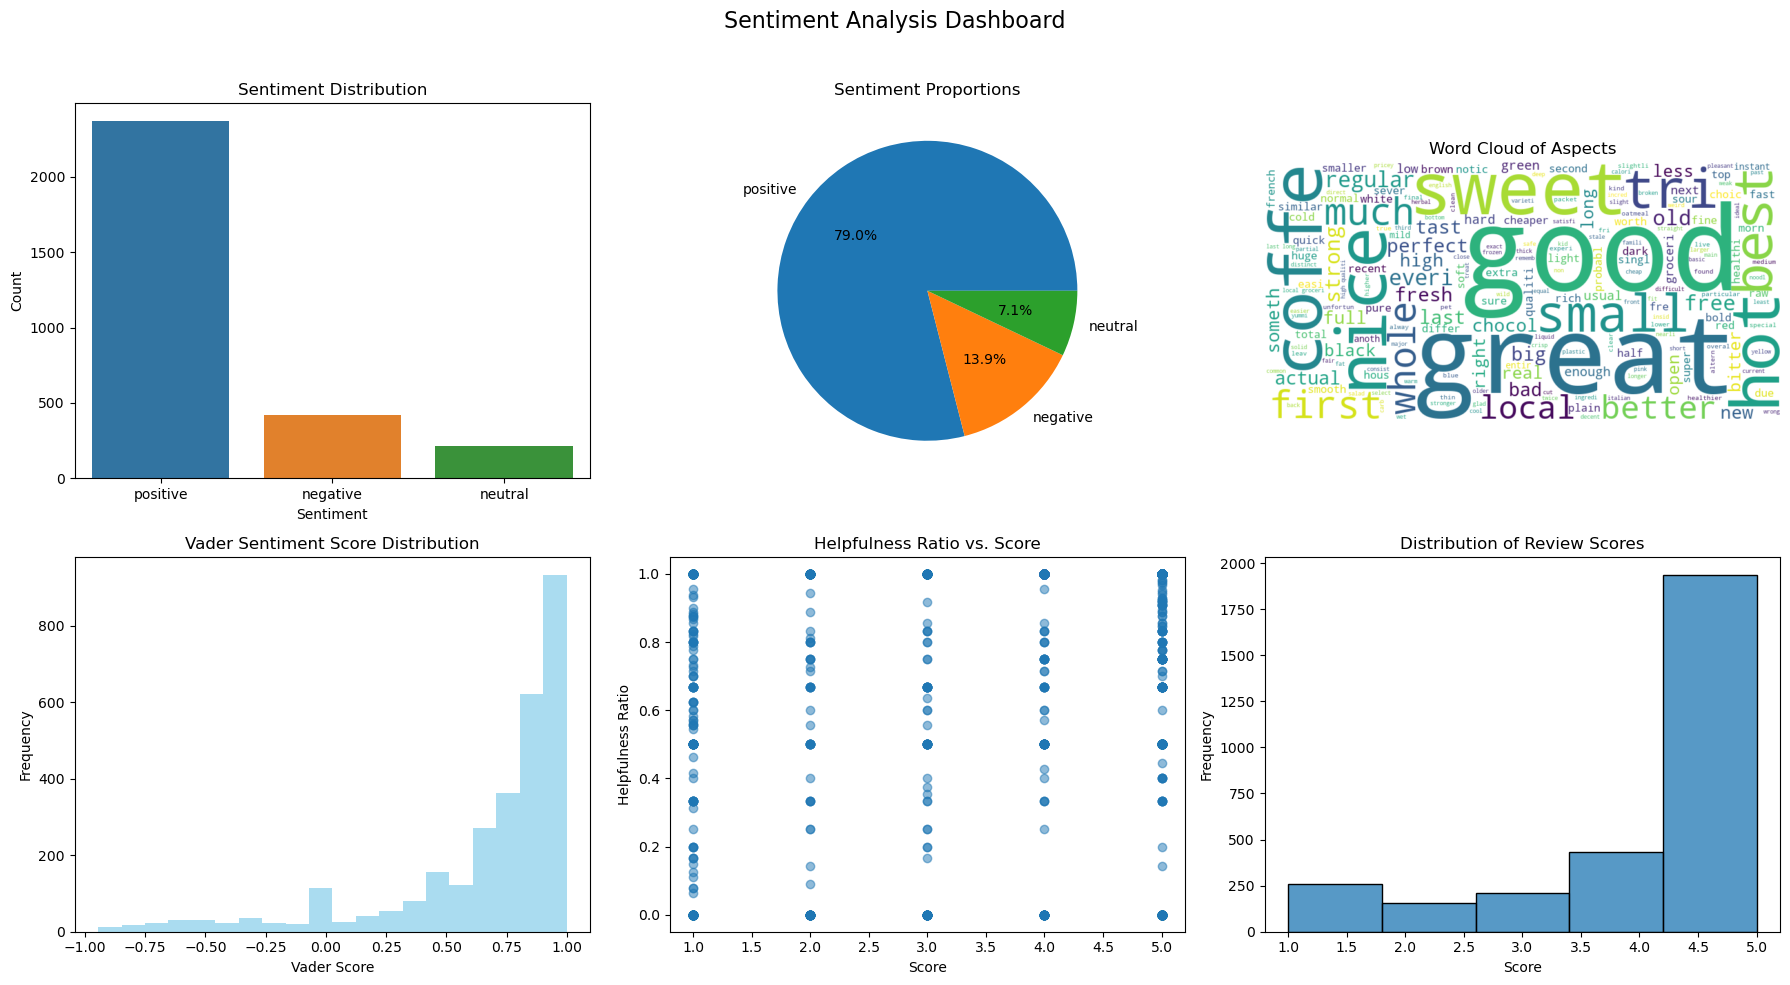

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud

# Set up a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sentiment Analysis Dashboard', fontsize=16)

# Plot 1: Sentiment Distribution (Bar Chart)
sentiment_counts = dt['Sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0, 0])
axes[0, 0].set_title("Sentiment Distribution")
axes[0, 0].set_xlabel("Sentiment")
axes[0, 0].set_ylabel("Count")

# Plot 2: Sentiment Proportions (Pie Chart)
axes[0, 1].pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%")
axes[0, 1].set_title("Sentiment Proportions")

# Plot 3: Word Cloud of Aspects
aspect_text = ' '.join(dt['Aspects'].explode().dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(aspect_text)
axes[0, 2].imshow(wordcloud, interpolation='bilinear')
axes[0, 2].set_title("Word Cloud of Aspects")
axes[0, 2].axis('off')

# Plot 4: Vader Sentiment Score Distribution (Histogram)
axes[1, 0].hist(dt['Vader'], bins=20, color='skyblue', alpha=0.7)
axes[1, 0].set_title("Vader Sentiment Score Distribution")
axes[1, 0].set_xlabel("Vader Score")
axes[1, 0].set_ylabel("Frequency")

# Plot 5: Helpfulness Ratio (Scatter Plot)
helpfulness_ratio = dt['HelpfulnessNumerator'] / dt['HelpfulnessDenominator']
axes[1, 1].scatter(dt['Score'], helpfulness_ratio, alpha=0.5)
axes[1, 1].set_title("Helpfulness Ratio vs. Score")
axes[1, 1].set_xlabel("Score")
axes[1, 1].set_ylabel("Helpfulness Ratio")

# Plot 6: Distribution of Review Scores (Histogram)
sns.histplot(data=dt, x='Score', bins=5, ax=axes[1, 2])
axes[1, 2].set_title("Distribution of Review Scores")
axes[1, 2].set_xlabel("Score")
axes[1, 2].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the dashboard
plt.show()